In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import joypy
import random
from datetime import datetime, timedelta, timezone

from scrape.api import DATETIME_FMT_STR
from scrape.summary import run as generate_summary

In [2]:
dt_now = datetime.utcnow().replace(tzinfo=timezone.utc).strftime(DATETIME_FMT_STR)
dt_pastpoint = datetime.utcnow().replace(tzinfo=timezone.utc) - timedelta(hours=48)

print(f"Date now: {dt_now}\nStart date for analysis: {dt_pastpoint}")

Date now: 2023-03-23T23:09Z
Start date for analysis: 2023-03-21 23:09:20.964800+00:00


We will show forecasts from 48 hours before the chosen start date, and also post-hoc "forecasts" and "actual" values taken for 24 hours after that date.

We do this for several hours' worth of data (several time-points) after the chosen start date:

In [3]:
hours_of_data = 12

In [4]:
# Produce summary data
generate_summary(input_directory="data/national_fw48h", endpoint="national_fw48h", output_directory="data")
generate_summary(input_directory="data/national_pt24h", endpoint="national_pt24h", output_directory="data")

summary_national_fw48h.csv
summary_national_pt24h.csv


In [6]:
dffw = pd.read_csv("data/summary_national_fw48h.csv", index_col=0, header=[0,1])
dfpt = pd.read_csv("data/summary_national_pt24h.csv", index_col=0, header=[0,1])
dfpt

intensity.forecast                                          \
time_difference                -00.5  -01.0  -01.5  -02.0  -02.5 -03.0 -03.5   
2023-03-13T03:00Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
2023-03-13T03:30Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
2023-03-13T04:00Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
2023-03-13T04:30Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
2023-03-13T05:00Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
...                              ...    ...    ...    ...    ...   ...   ...   
2023-03-23T19:00Z              116.0  116.0  116.0  116.0  116.0   NaN   NaN   
2023-03-23T19:30Z              114.0  114.0  114.0  114.0    NaN   NaN   NaN   
2023-03-23T20:00Z              104.0  104.0  104.0    NaN    NaN   NaN   NaN   
2023-03-23T20:30Z               96.0   96.0    NaN    NaN    NaN   NaN   NaN   
2023-03-23T21:00Z               90.0    NaN    NaN    NaN    NaN   NaN   NaN   

                                     ... intensity.actual                    \
time_difference   -04.0 -04.5 -05.0  ...            -19.5 -20.0 -20.5 -21.0   
2023-03-13T03:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-13T03:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-13T04:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-13T04:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-13T05:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
...                 ...   ...   ...  ...              ...   ...   ...   ...   
2023-03-23T19:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-23T19:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-23T20:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-23T20:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-23T21:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   

                                                       
time_difference   -21.5 -22.0 -22.5 -23.0 -23.5 -24.0  
2023-03-13T03:00Z   NaN   NaN   NaN   NaN   NaN  64.0  
2023-03-13T03:30Z   NaN   NaN   NaN   NaN  64.0  64.0  
2023-03-13T04:00Z   NaN   NaN   NaN  56.0  56.0  56.0  
2023-03-13T04:30Z   NaN   NaN  58.0  58.0  58.0  58.0  
2023-03-13T05:00Z   NaN  62.0  62.0  62.0  62.0  62.0  
...                 ...   ...   ...   ...   ...   ...  
2023-03-23T19:00Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-23T19:30Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-23T20:00Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-23T20:30Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-23T21:00Z   NaN   NaN   NaN   NaN   NaN   NaN  

[496 rows x 96 columns]

In [7]:
merged_df = pd.merge(dffw, dfpt, left_index=True, right_index=True, how="outer")
merged_df.index = pd.to_datetime(merged_df.index)

# Set columns to float and sort

# whole dataframe
# dfif.columns = dfif.columns.astype(float)
# dfif = dfif.reindex(sorted(dfif.columns), axis=1)

# one subset of columns in a multi-index
merged_df.columns = merged_df.columns.set_levels(merged_df.columns.levels[1].astype(float), level=1)
merged_df = merged_df.reindex(sorted(merged_df.columns, reverse=True), axis=1)
merged_df

intensity.forecast                              \
time_difference                         47.5   47.0   46.5   46.0   45.5   
2023-03-13 03:00:00+00:00                NaN    NaN    NaN    NaN    NaN   
2023-03-13 03:30:00+00:00                NaN    NaN    NaN    NaN    NaN   
2023-03-13 04:00:00+00:00                NaN    NaN    NaN    NaN    NaN   
2023-03-13 04:30:00+00:00                NaN    NaN    NaN    NaN    NaN   
2023-03-13 05:00:00+00:00                NaN    NaN    NaN    NaN    NaN   
...                                      ...    ...    ...    ...    ...   
2023-03-25 16:30:00+00:00               84.0   84.0   84.0   84.0   84.0   
2023-03-25 17:00:00+00:00              100.0  100.0  100.0  100.0  100.0   
2023-03-25 17:30:00+00:00              120.0  120.0  120.0  120.0  120.0   
2023-03-25 18:00:00+00:00              125.0  125.0  125.0  125.0  125.0   
2023-03-25 18:30:00+00:00              131.0  131.0  131.0  131.0  131.0   

                                                             ...  \
time_difference             45.0   44.5   44.0   43.5  43.0  ...   
2023-03-13 03:00:00+00:00    NaN    NaN    NaN    NaN   NaN  ...   
2023-03-13 03:30:00+00:00    NaN    NaN    NaN    NaN   NaN  ...   
2023-03-13 04:00:00+00:00    NaN    NaN    NaN    NaN   NaN  ...   
2023-03-13 04:30:00+00:00    NaN    NaN    NaN    NaN   NaN  ...   
2023-03-13 05:00:00+00:00    NaN    NaN    NaN    NaN   NaN  ...   
...                          ...    ...    ...    ...   ...  ...   
2023-03-25 16:30:00+00:00   84.0   84.0   84.0   84.0  84.0  ...   
2023-03-25 17:00:00+00:00  100.0  100.0  100.0  100.0   NaN  ...   
2023-03-25 17:30:00+00:00  120.0  120.0  120.0    NaN   NaN  ...   
2023-03-25 18:00:00+00:00  125.0  125.0    NaN    NaN   NaN  ...   
2023-03-25 18:30:00+00:00  131.0    NaN    NaN    NaN   NaN  ...   

                          intensity.actual                                \
time_difference                      -19.5 -20.0 -20.5 -21.0 -21.5 -22.0   
2023-03-13 03:00:00+00:00              NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-13 03:30:00+00:00              NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-13 04:00:00+00:00              NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-13 04:30:00+00:00              NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-13 05:00:00+00:00              NaN   NaN   NaN   NaN   NaN  62.0   
...                                    ...   ...   ...   ...   ...   ...   
2023-03-25 16:30:00+00:00              NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-25 17:00:00+00:00              NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-25 17:30:00+00:00              NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-25 18:00:00+00:00              NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-25 18:30:00+00:00              NaN   NaN   NaN   NaN   NaN   NaN   

                                                   
time_difference           -22.5 -23.0 -23.5 -24.0  
2023-03-13 03:00:00+00:00   NaN   NaN   NaN  64.0  
2023-03-13 03:30:00+00:00   NaN   NaN  64.0  64.0  
2023-03-13 04:00:00+00:00   NaN  56.0  56.0  56.0  
2023-03-13 04:30:00+00:00  58.0  58.0  58.0  58.0  
2023-03-13 05:00:00+00:00  62.0  62.0  62.0  62.0  
...                         ...   ...   ...   ...  
2023-03-25 16:30:00+00:00   NaN   NaN   NaN   NaN  
2023-03-25 17:00:00+00:00   NaN   NaN   NaN   NaN  
2023-03-25 17:30:00+00:00   NaN   NaN   NaN   NaN  
2023-03-25 18:00:00+00:00   NaN   NaN   NaN   NaN  
2023-03-25 18:30:00+00:00   NaN   NaN   NaN   NaN  

[608 rows x 288 columns]

<Axes: xlabel='time_difference'>

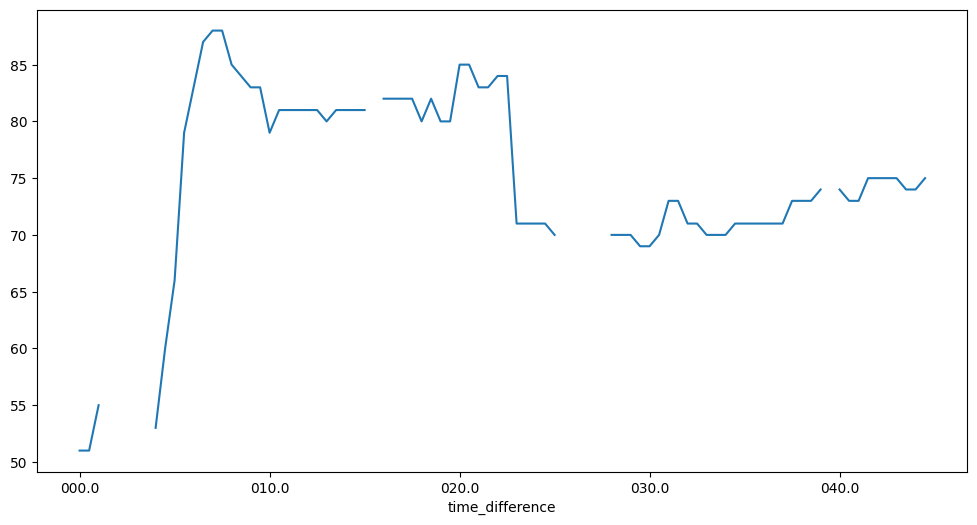

In [9]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

plt.figure()
dffw["intensity.forecast"].loc["2023-03-23T03:30Z"].plot()

In [10]:
# We will get data for half this many hours as time-points are half-hourly.
nrows = hours_of_data * 2
dates = [d for d in merged_df.index if d >= dt_pastpoint][:nrows]

# Alternatively plot some random dates
# dates = random.choices(merged_df.index, k=nrows)

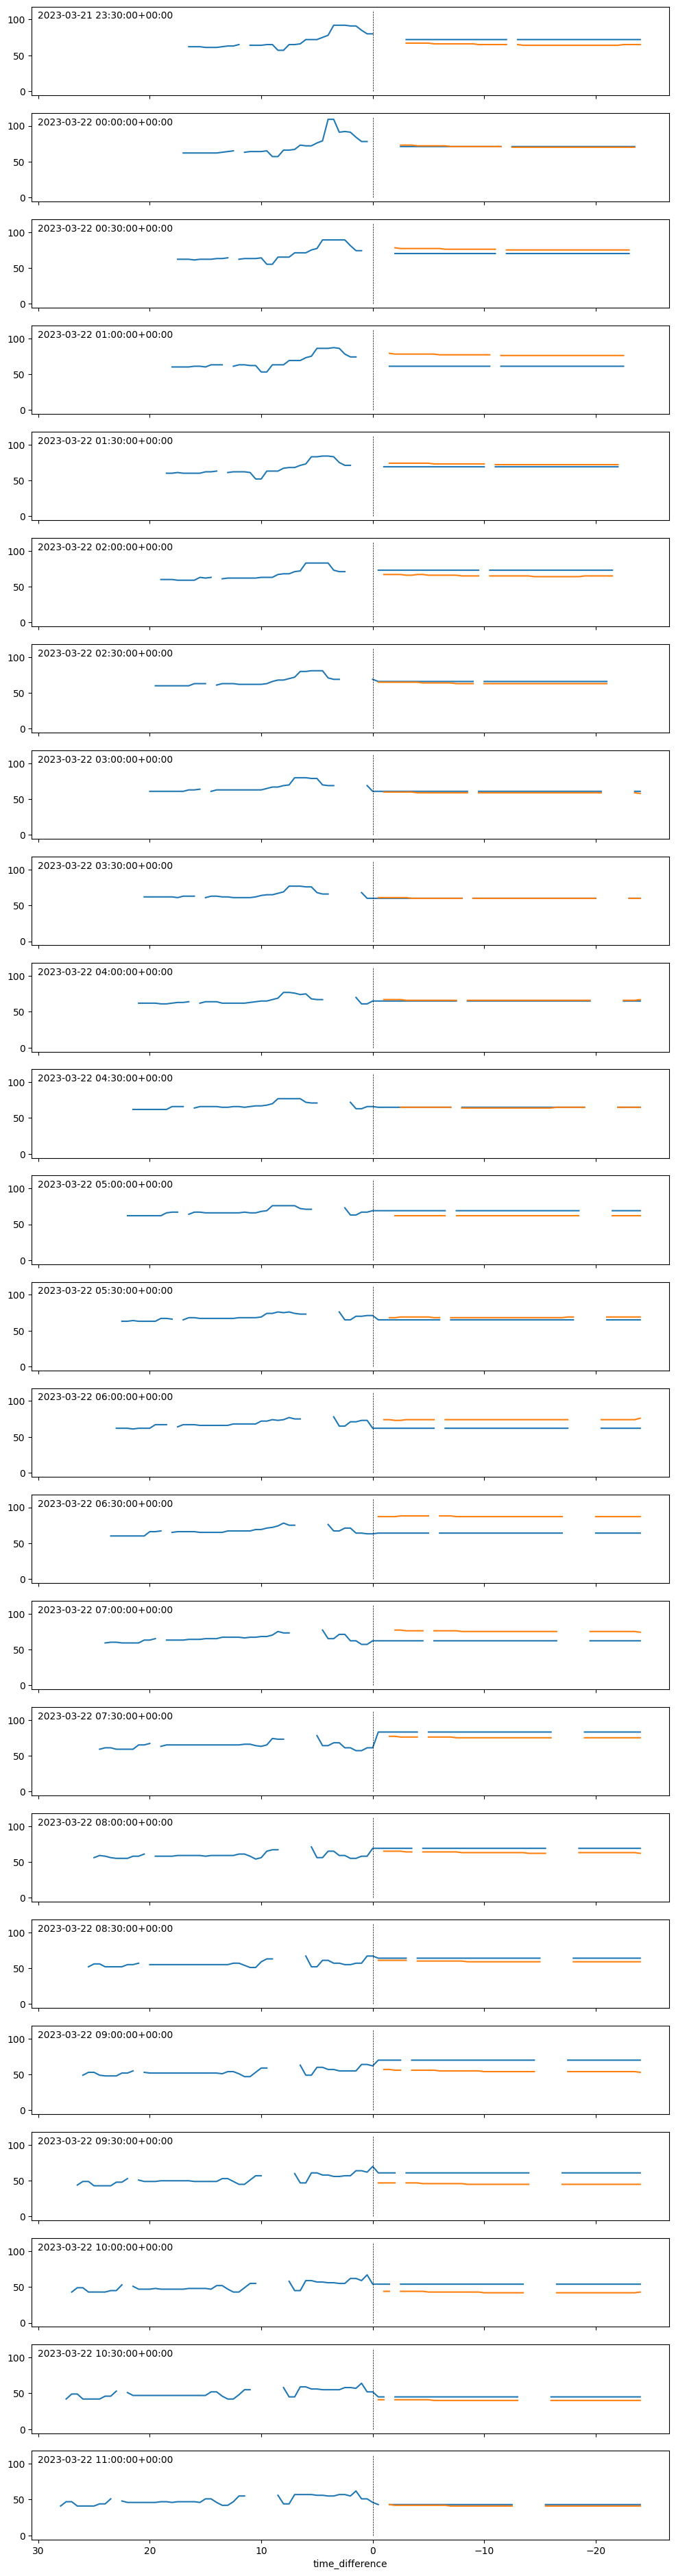

In [11]:
plt.rcParams['figure.figsize'] = [12, 48]
plt.rcParams['figure.dpi'] = 100

fig, axes = plt.subplots(nrows, 1, sharex=True, sharey="col")
for ix, ax in enumerate(axes):
    merged_df["intensity.forecast"].loc[dates[ix]].plot(ax=ax)
    merged_df["intensity.actual"].loc[dates[ix]].plot(ax=ax)
    ax.text(0.01, 0.95, dates[ix], horizontalalignment='left', verticalalignment='top', transform = ax.transAxes)
    
plt.gca().invert_xaxis()
ymax = plt.gca().get_ylim()[-1]

for ix, ax in enumerate(axes):
    ax.vlines(0.0,0,ymax, color='k', linestyle='--', linewidth=0.5)

plt.show()

Odd in the above that the post-hoc "forecast" value appears to be constant after about 30 minutes after the selected time-point, but the "actual" value continues to change.

The final forecast value doesn't appear until about 30 minutes after the start of the window; same with the "actual" value, which is only available after the end of the given window.

In [12]:
# Take a single value as the "actual"

merged_df["actual"] = merged_df["intensity.actual"].mean(axis=1)
merged_df["actual_median"] = merged_df["intensity.actual"].median(axis=1)

dfif = merged_df["intensity.forecast"]

df_forecasts_posthoc = dfif[[c for c in dfif.columns if float(c) < 0.0]]
merged_df["actual_forecast"] = df_forecasts_posthoc[-1.0]

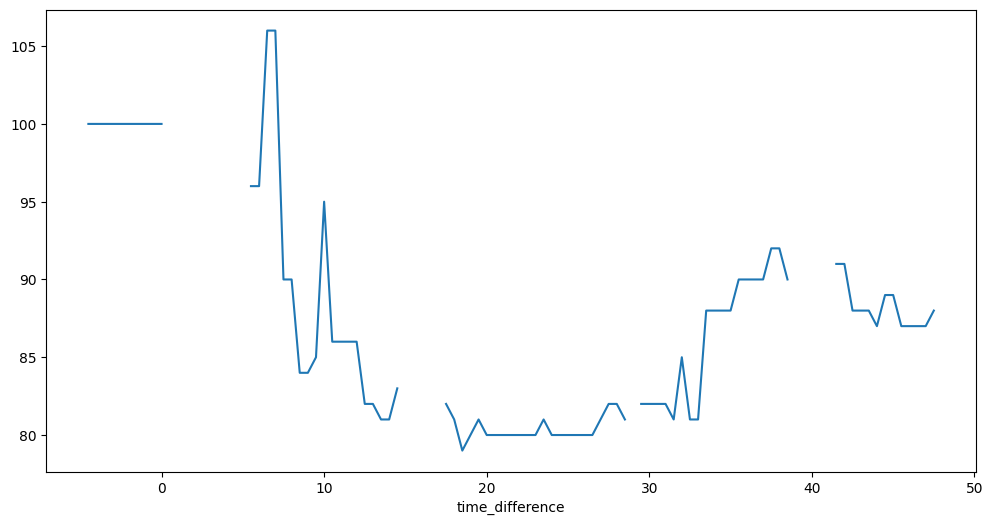

In [13]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

plt.figure()
ax = dfif.iloc[-100].plot()

In [14]:
dfsub = merged_df["intensity.forecast"].sub(merged_df["actual"], axis=0)
dfsub_pc = dfsub / merged_df["intensity.forecast"]

dfsub_forecasts = merged_df["intensity.forecast"].sub(merged_df["actual_forecast"], axis=0)
dfsub_fc_pc = dfsub_forecasts / merged_df["intensity.forecast"]

The following Joy / Ridgeline plots are histograms taken across all available data.

For each of the 96 half-hourly timepoints prior to any given target window, we count into a histogram bin if the forecast has this much % error from the final forecast or mean "actual" value (which, confusingly, can change).

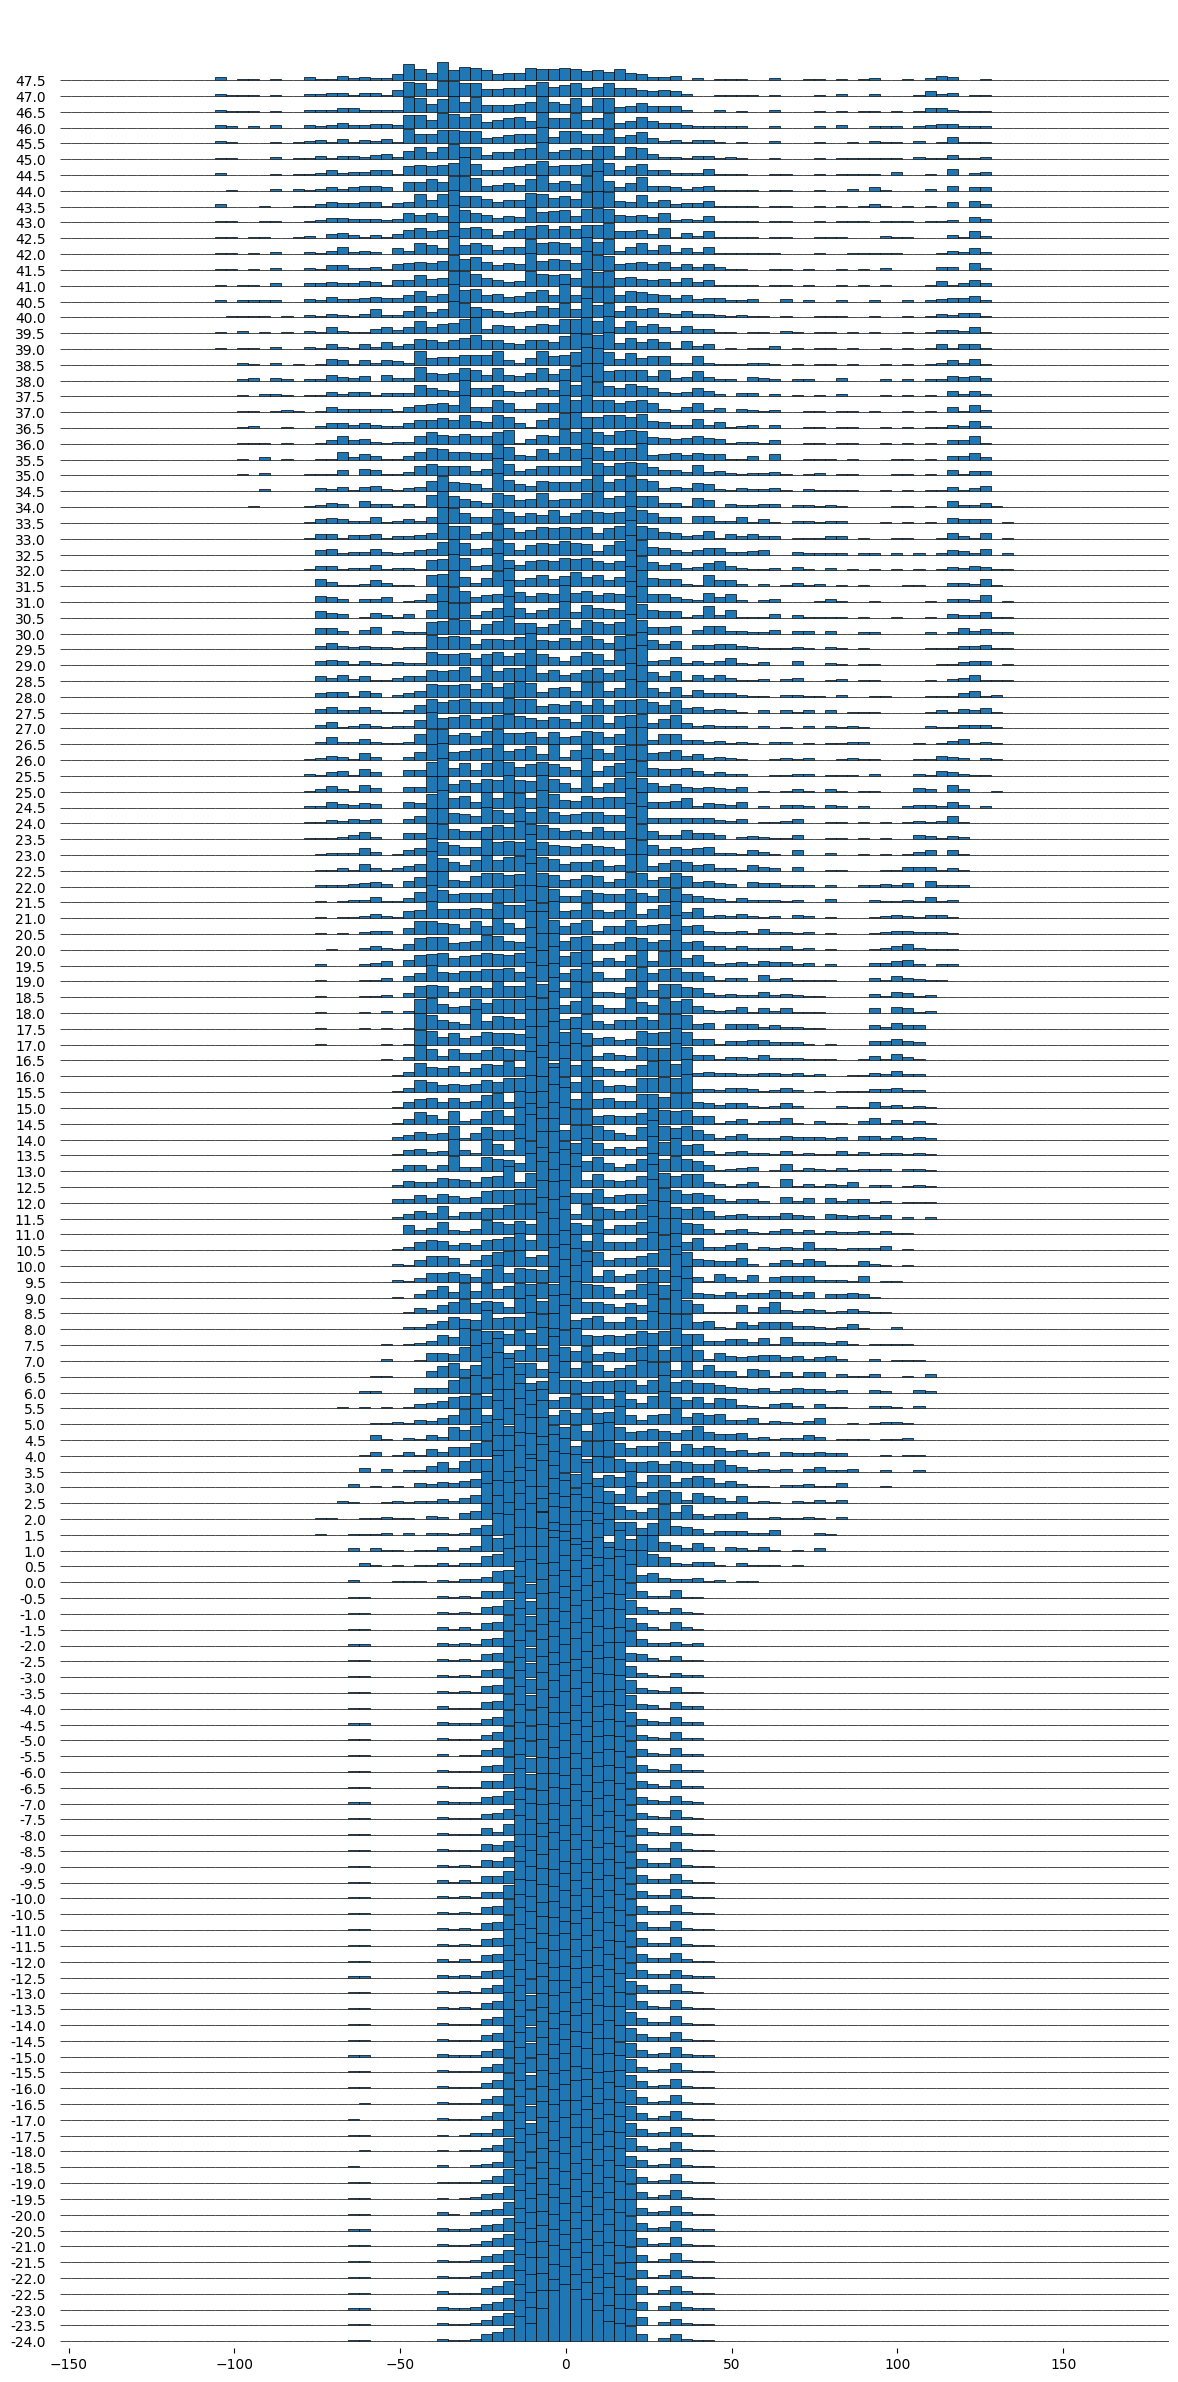

In [15]:
plt.rcParams['figure.figsize'] = [12, 24]
plt.rcParams['figure.dpi'] = 100

# Plot histograms of the actual data differences
# fig, ax = joypy.joyplot(dfsub, linewidth=0.5)
fig, ax = joypy.joyplot(dfsub, hist=True, bins=100, linewidth=0.5)

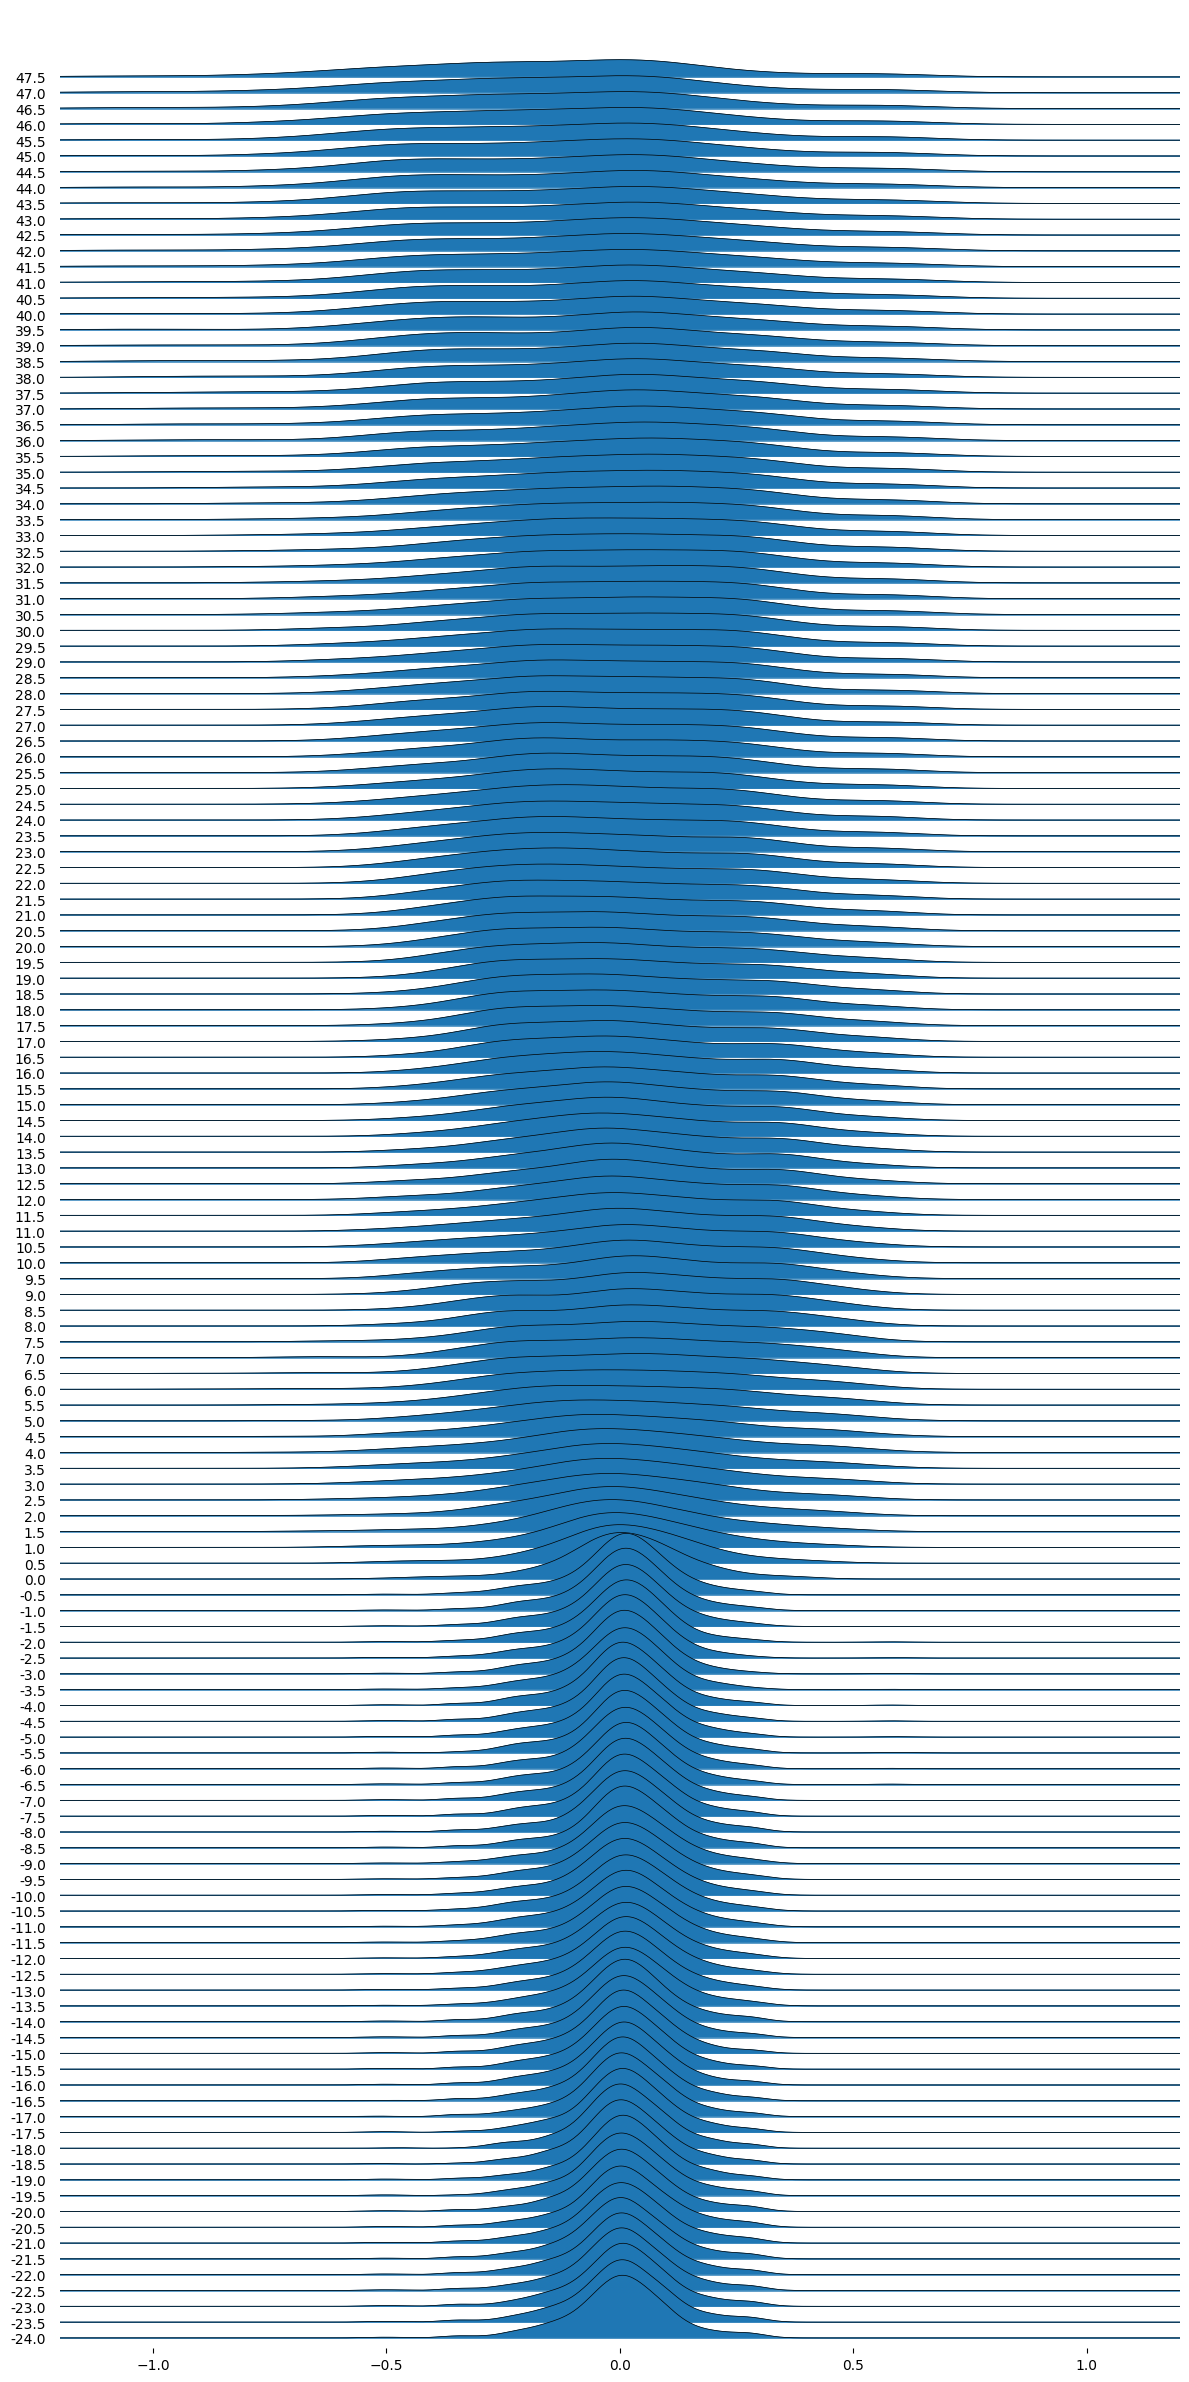

In [16]:
# Show a smoothed plot of the relative difference between the forecast and the mean "actual" value after.
fig, axes = joypy.joyplot(dfsub_pc, linewidth=0.5)
for ax in axes:
    ax.set_xlim(-1.2, 1.2)

/Users/nick.powell/.virtualenvs/carbon-intensity-forecast-tracking/lib/python3.10/site-packages/joypy/joyplot.py:286: UserWarning: The data contains a group with a single distinct value (0.0) having infinite probability density. Consider using a different visualization.
  warnings.warn("The data contains a group with a single distinct value ({}) "


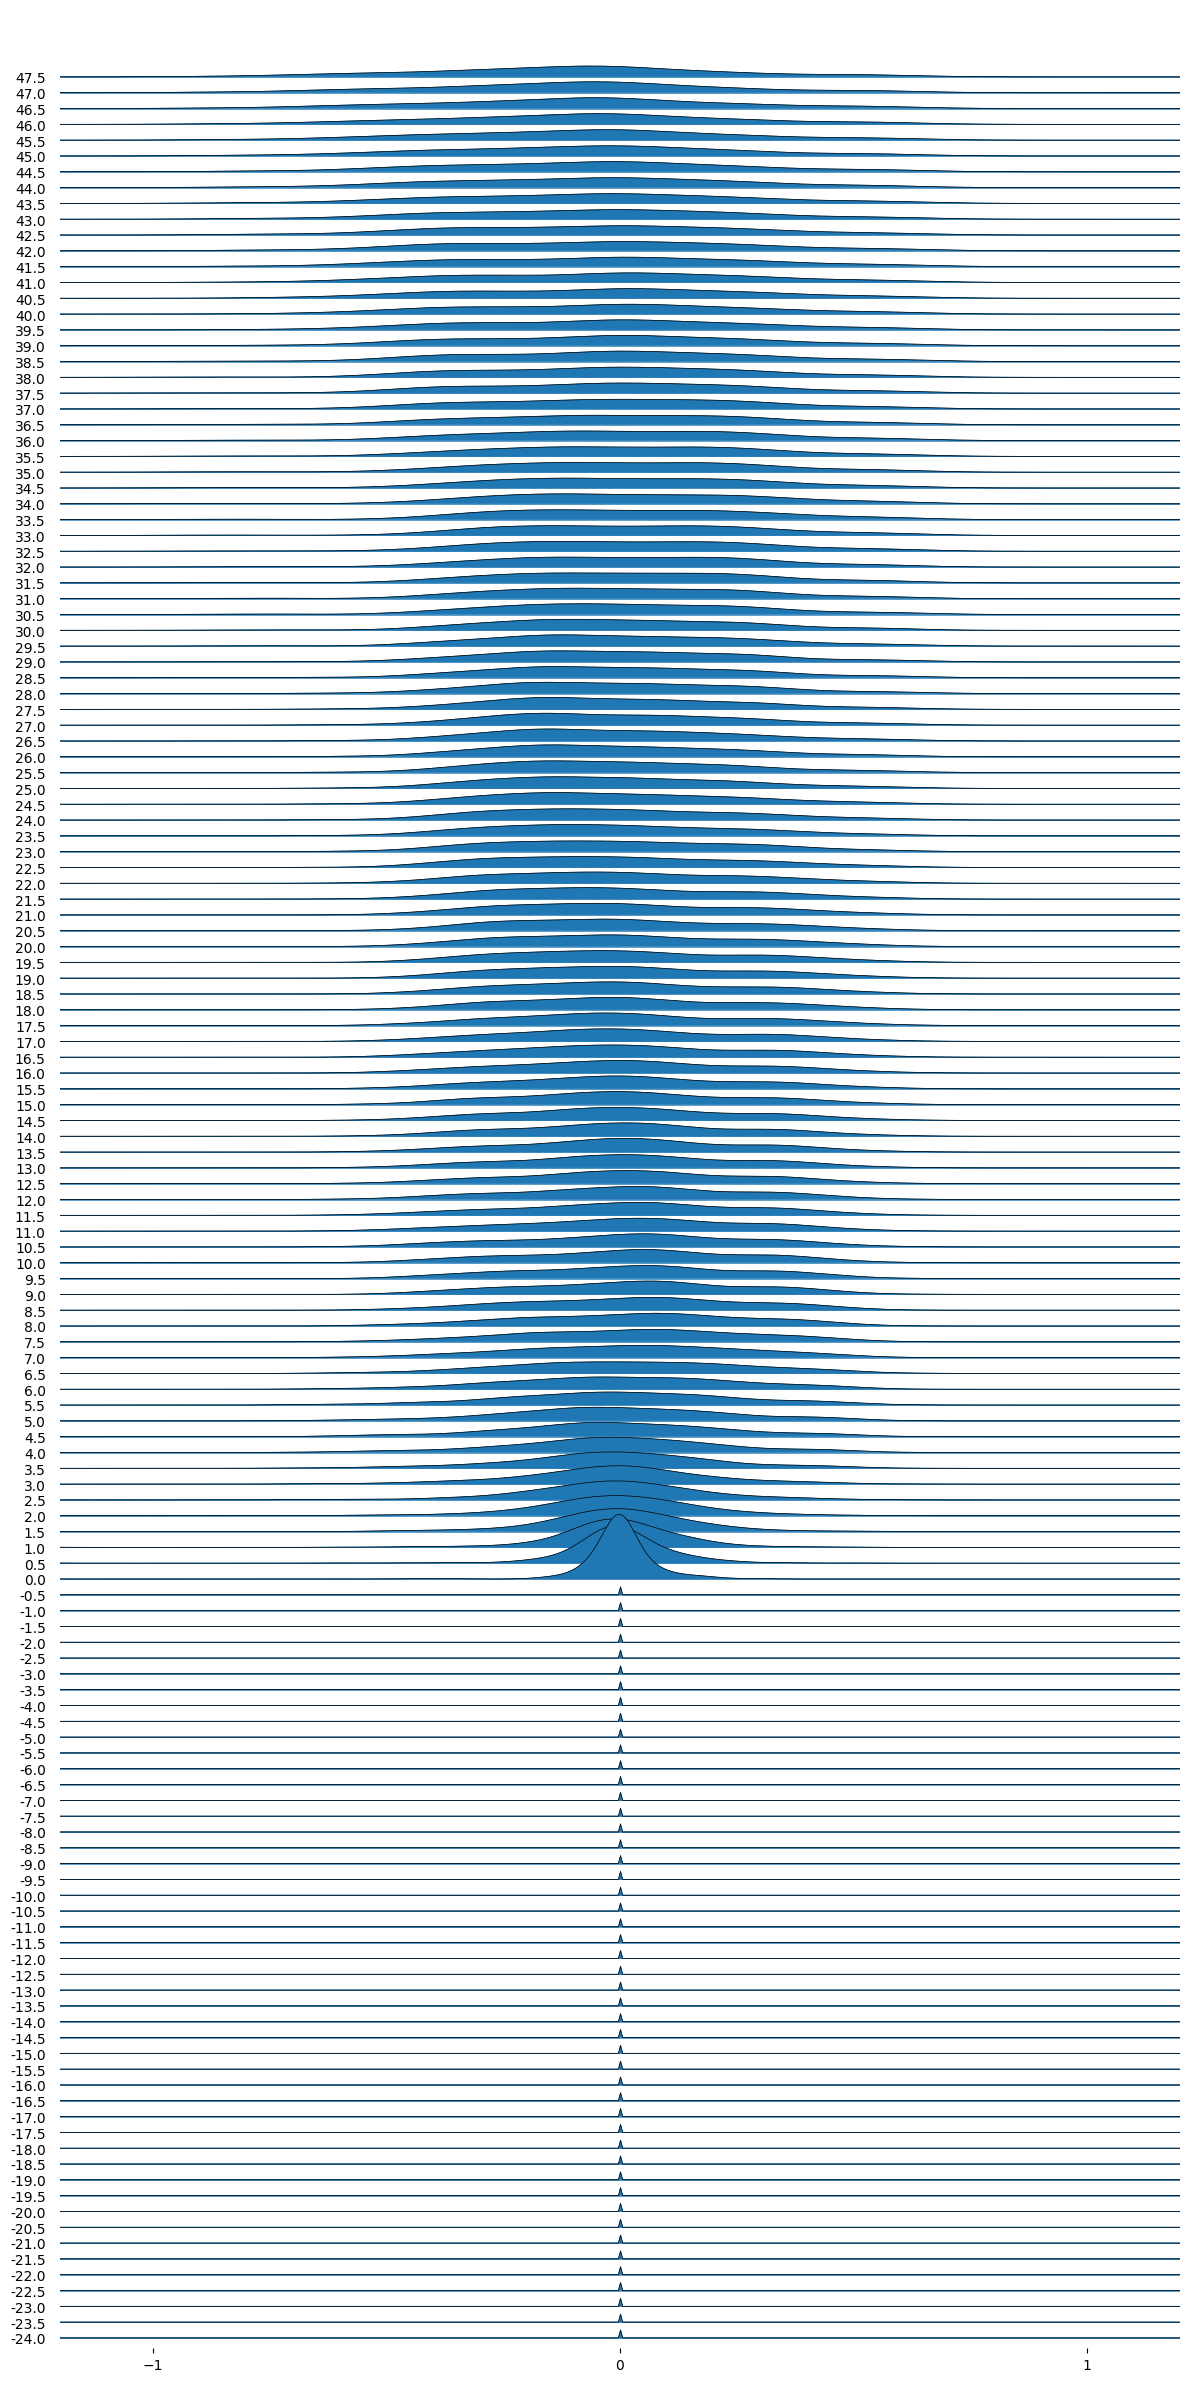

In [17]:
fig, axes = joypy.joyplot(dfsub_fc_pc, linewidth=0.5)
for ax in axes:
    ax.set_xlim(-1.2, 1.2)